# Analyse des Méthodes de Cleaning de Matrice de Covariance - Données Synthétiques

Ce notebook explore et compare diverses méthodes d'estimation robuste de matrices de covariance sur des données synthétiques. 
L'objectif est d'évaluer la performance de techniques comme le shrinkage linéaire, le shrinkage non-linéaire, et les estimateurs basés sur la théorie des matrices aléatoires (Marchenko-Pastur).

## Structure du notebook:
1. **Fonctions utilitaires**: Génération de données et calcul de métriques
2. **Benchmarks simples**: Évaluation basique en fonction du ratio p/n
3. **Monte Carlo**: Simulations répétées avec frontières efficientes
4. **Analyses spectrales**: Étude des valeurs propres et comportement asymptotique

## Table des Matières

### I. Fondations
- **Cellule 3**: Imports et setup
- **Cellule 4**: Fonctions utilitaires (génération de données, métriques)
- **Cellule 5**: Méthodes avancées (POET, sélection de facteurs)

### II. Benchmarks de Performance
- **Benchmark 1** (Cellules 6-7): Gain du Linear Shrinkage vs ratio p/n
- **Benchmark 2** (Cellules 8-9): Comparaison via perte MV (AS vs Sample)
- **Benchmark 3** (Cellules 10-11): Oracle moyen en fonction du ratio
- **Benchmark 4** (Cellules 12-14): Comparaison complète (AS, LS, MP, Oracle) - Portefeuille
- **Benchmark 5** (Cellules 15-16): Norme de Frobenius sur corrélations
- **Benchmark 6** (Cellules 17-18): Convergence avec la taille d'échantillon n
- **Benchmark 7** (Cellules 19-23): Test de Kolmogorov-Smirnov

### III. Analyses Spectrales et Structurelles
- **Cellules 24-25**: Distribution Pareto et impact du paramètre alpha
- **Cellule 26**: Analyse de diversification du portefeuille GMV

### IV. Données Empiriques et Valeurs Propres
- **Cellules 27-28**: Analyse des spectres empiriques vs théoriques

### V. Simulation Monte Carlo - Frontières Efficientes
- **Cellules 29-30**: Monte Carlo complet avec quantiles 1%/99%

In [1]:
# ===== SETUP ET IMPORTS =====
from methods import cleaning_methods  # Module contenant les estimateurs de covariance
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
from scipy.stats import ks_2samp, pareto
import pandas as pd

In [2]:
# ===== FONCTIONS UTILITAIRES DE BASE =====
# Cette section définit les outils fondamentaux pour générer des données et évaluer les estimateurs

def generate_data(T, p, nu=10):
    # Modèle factoriel pour la vraie covariance
    k = 1
    B = 0.01 * np.random.randn(p, k)
    Psi = 0.05 * np.diag(np.exp(np.random.normal(-4, 1, p)))
    Sigma_true = B @ B.T + Psi

    # Loi de student pour des queues plus lourdes qu'une loi normale
    Z = np.random.standard_t(nu, size=(T, p))
    Z = Z / np.sqrt(nu / (nu - 2))  # variance = 1

    # Décomposition de Cholesky: L est triangulaire inférieure
    L = np.linalg.cholesky(Sigma_true)
    X = Z @ L.T

    return X, Sigma_true

def gmv_weights(S):
    """Retourne les poids du portefeuille Global Minimum Variance."""
    p = S.shape[0]
    one = np.ones(p)
    w = np.linalg.solve(S, one)
    w /= one @ w
    return w

def generate_sample(n,Sigma, nu = 5):
    Z = np.random.standard_t(nu, size=(n, Sigma.shape[0]))
    Z = Z / np.sqrt(nu / (nu - 2))  # variance = 1

    # Décomposition de Cholesky: L est triangulaire inférieure
    L = np.linalg.cholesky(Sigma)
    X = Z @ L.T

    return X

def markowitz_frontier(S_is, mu_is, Sigma, n_points=150):
    """Calcule la frontière efficiente de Markowitz.
    
    - Optimisation des poids en-sample (via S_is et mu_is)
    - Évaluation du risque et rendement out-of-sample (via Sigma)
    - Retourne risque, rendement, et ratio de Sharpe pour chaque rendement cible
    """
    p = len(mu_is)
    ones = np.ones(p)

    Sinv = np.linalg.pinv(S_is)

    # Coefficients de la paramétrisation de la frontière
    A = ones @ Sinv @ ones
    B = ones @ Sinv @ mu_is
    C = mu_is @ Sinv @ mu_is
    D = A * C - B**2

    # Grille de rendements cibles
    mu_gmv = (ones @ Sinv @ mu_is) / (ones @ Sinv @ ones)
    mu_min = 0.8 * mu_is.min()
    mu_max = 0.8 * mu_is.max()
    
    mu_targets = np.linspace(mu_min, mu_max, n_points)

    risks = []
    rets = []
    sharpes = []
    rf = 1.2e-4  # Taux sans risque annualisé

    for mu_star in mu_targets:
        w = ((C - B * mu_star) / D) * (Sinv @ ones) \
          + ((A * mu_star - B) / D) * (Sinv @ mu_is)

        risk = np.sqrt(w @ Sigma @ w)
        ret = w @ mu_is
        sharpe = (ret - rf) / risk if risk > 0 else np.nan

        risks.append(risk)
        rets.append(ret)
        sharpes.append(sharpe)

    return risks, rets, sharpes

def L_mv(Sigma_hat, Sigma):
    """Calcule la perte de Stein pour l'estimation de covariance.
    
    La perte de Stein est invariante par translation et contient 
    à la fois les erreurs de sur-estimation et sous-estimation.
    """
    p = Sigma.shape[0]

    d, U = np.linalg.eigh(Sigma_hat)
    d = np.maximum(d, 1e-8)  # Stabilité numérique
    Sigma_hat_inv = U @ np.diag(1 / d) @ U.T

    Sigma_inv = np.linalg.inv(Sigma)

    num = np.trace(Sigma_hat_inv @ Sigma @ Sigma_hat_inv) / p
    den = (np.trace(Sigma_hat_inv) / p) ** 2
    cst = 1 / (np.trace(Sigma_inv) / p)

    return num / den - cst

def corr(M):
    """Convertit une matrice de covariance en matrice de corrélation."""
    d = np.sqrt(np.diag(M))
    return M / np.outer(d, d)

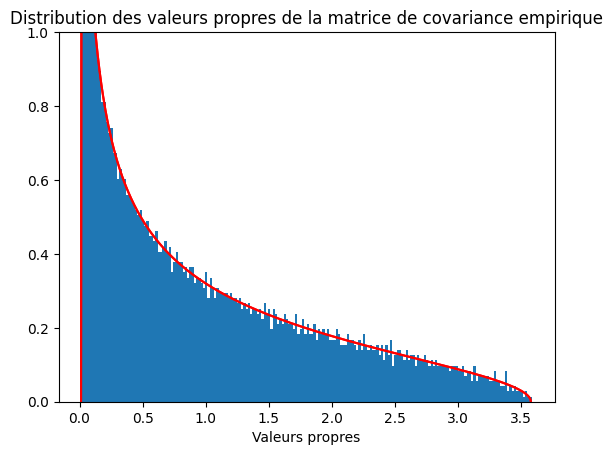

In [3]:
import numpy as np
import matplotlib.pyplot as plt

p = 2*2000
n = 2*2520
B = np.random.randn(p, n)
Sigma = (B @ B.T)/n
eig = np.linalg.eigvalsh(Sigma)

sigma = 1
g = p/n
lambda_minus = (1 - np.sqrt(g))**2
lambda_plus  = (1 + np.sqrt(g))**2


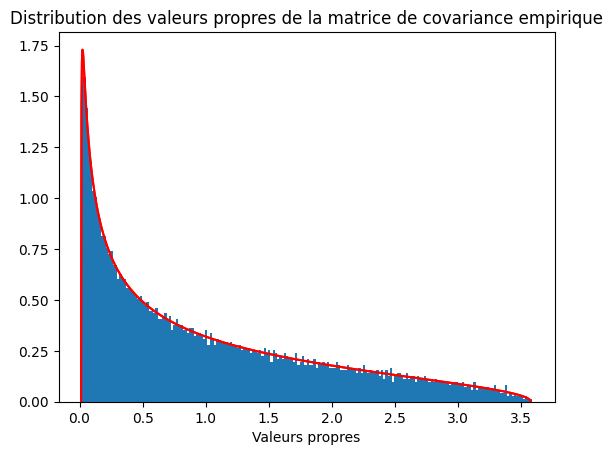

In [4]:

x = np.linspace(lambda_minus, lambda_plus, 1000)
mp = np.sqrt((lambda_plus - x)*(x - lambda_minus)) / (sigma**2 * 2*np.pi*x*g)

plt.plot(x, mp, 'r', label="MP continu")
plt.figure
plt.plot(x, mp, 'r', label="MP continu")
plt.hist(eig, density = True, bins = 200)
plt.title("Distribution des valeurs propres de la matrice de covariance empirique")
plt.xlabel("Valeurs propres")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

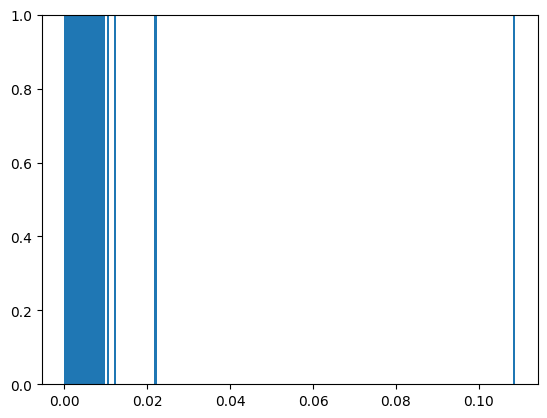

In [66]:
X, Sigma = generate_data(252, 1000)

eig = np.linalg.eigvalsh(Sigma)
plt.figure
plt.hist(eig, density = True, bins = 200)
plt.ylim(0,1)
plt.show

In [323]:
# ===== MÉTHODES AVANCÉES: POET ET SÉLECTION DE FACTEURS =====
# Ces fonctions implémentent le cleaning par estimation sparse et la décomposition spectrale

def covariance_empirique(Xc):
    """Calcule la matrice de covariance empirique (estimateur sample)."""
    cov_matrice = np.cov(Xc.T, ddof=1)
    return cov_matrice

def decomp_spectrale_triee(S):
    """Décompose en valeurs/vecteurs propres et les trie en ordre décroissant."""
    Ssym = (S + S.T) / 2.0  # Force la symétrie (tolérance numérique)
    lam, V = np.linalg.eigh(Ssym) 
    idx = np.argsort(lam)[::-1]  # Ordre décroissant
    return [lam[idx], V[:, idx]]

def choisir_K(X, Kmax):
    """Sélectionne le nombre optimal de facteurs via critère d'information.
    
    Utilise un critère de type BIC pour éviter l'over-fitting et 
    capturer les structures principales de la covariance.
    """
    T, p = X.shape
    Y = X.T 
    lam, V = np.linalg.eigh(Y.T @ Y)
    V = V[:, ::-1]
    g = (p + T) / (p * T) * np.log((p * T) / (p + T))
    IC = np.zeros(Kmax + 1)
 
    IC[0] = np.log(np.linalg.norm(Y, "fro")**2 / (p * T))
 
    # k >= 1
    for k in range(1, Kmax + 1):
        F = np.sqrt(T) * V[:, :k]         
        P = (F @ F.T) / T                 
        R = Y - Y @ P                     
        Vk = np.linalg.norm(R, "fro")**2 / (p * T)
        IC[k] = np.log(Vk) + k * g
 
    return int(np.argmin(IC))
 
def seuillage_adaptatif(U, T):
    """Applique un seuillage adaptatif au résidu de covariance.
    
    Utilise un seuil dépendant de la variance pour capturer les corrélations 
    faibles mais significatives tout en éliminant le bruit.
    """
    C = 2
    p = U.shape[0]
    omega_T = (1.0 / np.sqrt(p)) + np.sqrt(np.log(p) / T)
    diag_U = np.diag(U)
    matrice_std = np.sqrt(np.outer(diag_U, diag_U))
    Tau = C * omega_T * matrice_std
    U_th = U * (np.abs(U) >= Tau)
    np.fill_diagonal(U_th, diag_U)  # Préserve la diagonale
    return U_th
 
def poet_cov_Estimation_rendements(X, Kmax):
    """Estime la covariance via POET (Principal Orthogonal complEment Thresholding).
    
    Cette méthode:
    1. Extrait K facteurs principaux (composante faible rang)
    2. Seuille le résidu sparse (composante sparse)
    3. Recombine les deux pour une estimation robuste
    """
    T = X.shape[0]
    S = covariance_empirique(X)
    K = choisir_K(X, Kmax=Kmax)
    lam, V = decomp_spectrale_triee(S)
    Vk = V[:, :K]
    Sk = Vk @ np.diag(lam[:K]) @ Vk.T
    U = S - Sk
    U_th = seuillage_adaptatif(U, T=T)
    Sigma_hat = Sk + U_th
    return Sigma_hat, K

## I. Fondations Théoriques

### Génération de Données
- **Données synthétiques**: N(0, Σ) via décomposition de Cholesky pour stabilité numérique
- Formule: `X = Z @ L.T` où `L = chol(Σ)` et `Z ~ N(0, I)`

### Métriques d'Évaluation
- **Perte de Stein**: Invariante par translation, pénalise sur/sous-estimation
- **Norme Frobenius**: Erreur absolue sur matrices (échelle}
- **Corrélations**: Erreur sur structure de dépendance (invariant d'échelle)

In [3]:
# ===== BENCHMARK 1: Gain du Linear Shrinkage vs Ratio p/n =====
# Évalue la performance du shrinkage linéaire en fonction de la dimension relative

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

ratios = np.linspace(0.2, 5, 30)
p = 100
n_mc = 5  # nombre de répétitions Monte Carlo

gains_mse = []
gains_fro = []
b2_d2_vals = []

for ratio in tqdm(ratios):
    n = max(1, int(p/ratio))

    gain_mc = 0.0
    b2_d2_mc = 0.0

    for _ in range(n_mc):
        X, Sigma = generate_data(n,p)

        cleaner = cleaning_methods(X)

        # --- Gain en norme de Frobenius ---
        S = X.T @ X / n
        Ssh = cleaner.linear_shrinkage()
        gain_mc_fro = (np.linalg.norm(S - Sigma, 'fro')**2 - np.linalg.norm(Ssh - Sigma, 'fro')**2) / (np.linalg.norm(S - Sigma, 'fro')**2)
        gain_mc += gain_mc_fro

        # --- Diagnostic: Ratio b^2 / d^2 (terme de bias / terme de variance) ---
        mn = np.trace(S) / p
        dn2 = (np.linalg.norm(S - mn * np.eye(p), 'fro')**2)/p

        if dn2 > 0:
            bn2_barre = 0.0
            for k in range(n):
                xk = X[k, :].reshape(p, 1)
                Sk = xk @ xk.T
                bn2_barre += (np.linalg.norm(Sk - S, 'fro')**2)/p

            bn2_barre /= n**2
            bn2 = min(bn2_barre, dn2)
            b2_d2_mc += bn2 / dn2

    gains_fro.append(gain_mc / n_mc)
    b2_d2_vals.append(b2_d2_mc / n_mc)

100%|██████████| 30/30 [00:00<00:00, 46.10it/s]


## II. Benchmarks Numériques

Les 7 benchmarks suivants évaluent la performance comparative des méthodes de cleaning:
1. Gain du shrinkage linéaire vs ratio p/n
2. Comparaison via perte MV (AS vs Sample)
3. Oracle moyen (borne théorique)
4. Comparaison complète (Portefeuille GMV)
5. Erreur de corrélation
6. Convergence avec taille d'échantillon
7. Test de Kolmogorov-Smirnov (qualité des distributions)

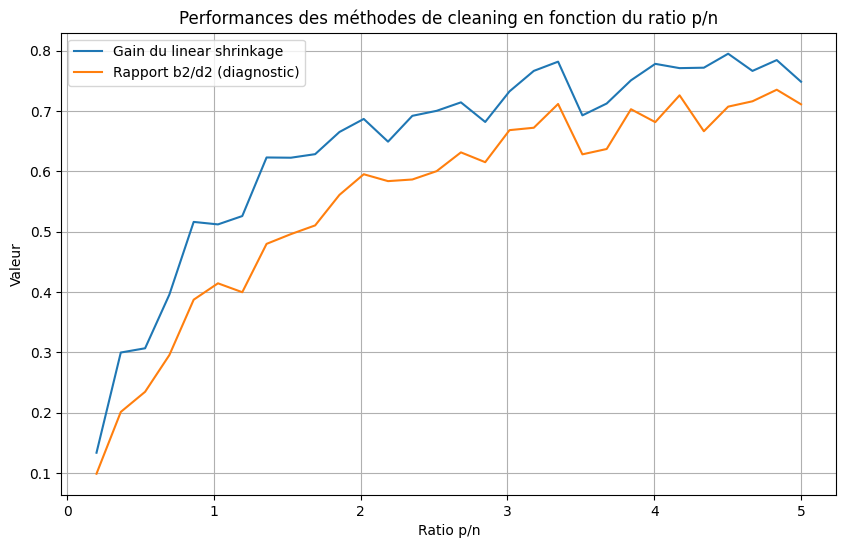

In [4]:
# Visualisation du benchmark 1
plt.figure(figsize=(10, 6))
plt.plot(ratios, gains_fro, label='Gain du linear shrinkage')
plt.plot(ratios, b2_d2_vals, label='Rapport b2/d2 (diagnostic)')

plt.title('Performances des méthodes de cleaning en fonction du ratio p/n')
plt.xlabel('Ratio p/n')
plt.ylabel('Valeur')
plt.legend()
plt.grid(True)

# Afficher le graphique
plt.show()

In [5]:
# ===== BENCHMARK 2: Comparaison des méthodes via la perte MV =====
# Évalue le shrinkage non-linéaire (AS) versus d'autres méthodes

import time as time 
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm

MC = 10  # Nombre d'itérations Monte Carlo
n = 252
p_a_tester = [500, 750, 1000, 1250]
gains_ao = []
gains_ls = []
gains_as = []
gains_etoile = []
gains_mp = []
gains_mp2 = []
gains_s = []

def mc_gain_one_run(n, p):
    """Une itération Monte Carlo: compare AS à l'estimateur sample."""
    X, Sigma = generate_data(n,p)
    X_centre = X - X.mean(axis=0)
    
    cleaner = cleaning_methods(X_centre)
    S_as = cleaner.analytical_shrinkage() 
    S_ls = cleaner.linear_shrinkage()
    S_mp = cleaner.mp()
    S_mp2 = cleaner.mp2()
    S_etoile = cleaner.oracle_mv(Sigma)
    S_ao = cleaner.average_oracle()
    S = X.T @ X/n  

    loss_s = L_mv(S, Sigma)
    loss_as = L_mv(S_as, Sigma)
    loss_ls = L_mv(S_ls, Sigma)
    loss_mp = L_mv(S_mp, Sigma)
    loss_mp2 = L_mv(S_mp2, Sigma)
    loss_etoile = L_mv(S_etoile, Sigma)
    #loss_ao = L_mv(S_ao, Sigma)

    return loss_as, loss_s, loss_ls, loss_mp, loss_mp2, loss_etoile#, loss_ao

for p in tqdm(p_a_tester):

    # Parallélisation sur plusieurs itérations MC
    results = Parallel(n_jobs=-1, backend="threading")(
        delayed(mc_gain_one_run)(n, p) for _ in range(MC)
    )

    # Agrégation des résultats
    gain_as = sum(r[0] for r in results) / MC
    gain_s = sum(r[1] for r in results) / MC
    gain_ls = sum(r[2] for r in results) / MC
    gain_mp = sum(r[3] for r in results) / MC
    gain_mp2 = sum(r[4] for r in results) / MC
    #gain_ao = sum(r[5] for r in results) / MC
    gain_etoile = sum(r[5] for r in results) / MC
    
    # Calcul du gain relatif (en %)
    gain_as = ((gain_s - gain_as) / (gain_s + 1e-10))
    gain_ls = ((gain_s - gain_ls) / (gain_s + 1e-10))
    gain_mp = ((gain_s - gain_mp) / (gain_s + 1e-10))
    gain_mp2 = ((gain_s - gain_mp2) / (gain_s + 1e-10))
    #gain_ao = ((gain_s - gain_ao) / (gain_s + 1e-10))
    gain_etoile = ((gain_s - gain_etoile) / (gain_s + 1e-10))
 
    gains_as.append(gain_as)
    gains_ls.append(gain_ls)
    gains_mp.append(gain_mp)
    gains_mp2.append(gain_mp2)
    gains_etoile.append(gain_etoile)
    #gains_ao.append(gain_ao)

100%|██████████| 4/4 [19:00<00:00, 285.22s/it]


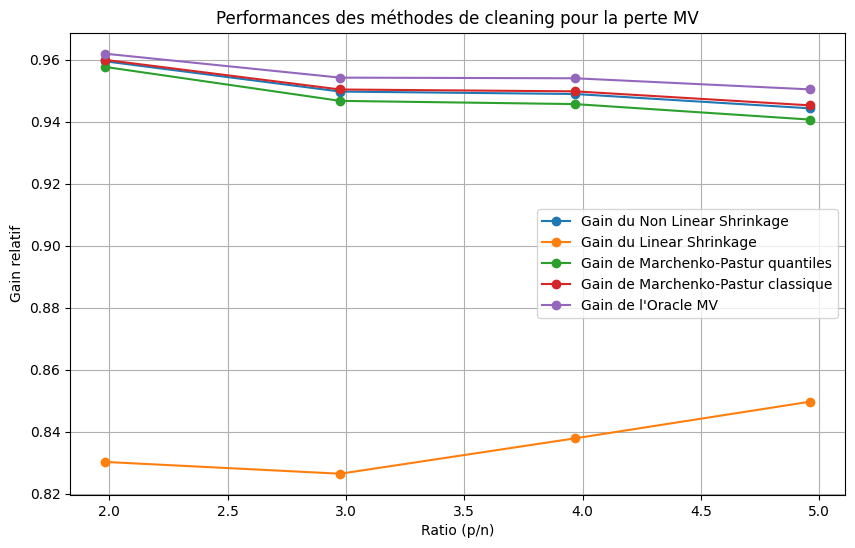

In [7]:
# Visualisation du benchmark 2: Gain du Non-Linear Shrinkage

plt.figure(figsize=(10, 6))
plt.plot([p/n for p in p_a_tester], gains_as, label='Gain du Non Linear Shrinkage', marker='o')
plt.plot([p/n for p in p_a_tester], gains_ls, label='Gain du Linear Shrinkage', marker='o')
plt.plot([p/n for p in p_a_tester], gains_mp, label='Gain de Marchenko-Pastur quantiles', marker='o')
plt.plot([p/n for p in p_a_tester], gains_mp2, label='Gain de Marchenko-Pastur classique', marker='o')
plt.plot([p/n for p in p_a_tester], gains_etoile, label='Gain de l\'Oracle MV', marker='o')
#plt.plot([p/n for p in p_a_tester], gains_ao, label='Gain de l\'Average Oracle', marker='o')

#plt.ylim(0, 1)
plt.title('Performances des méthodes de cleaning pour la perte MV')
plt.xlabel('Ratio (p/n)')
plt.ylabel('Gain relatif')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ===== BENCHMARK 4: Comparaison complète sur risque de portefeuille =====
# Compare AS, LS, MP classique, MP avec quantile, AO et Oracle MV en termes de performance réelle (portefeuille GMV)

import time as time 
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm

MC = 50  # Itérations Monte Carlo
ratios = [4, 6, 8, 10]  # Différents ratios p/n
n = 252  # Taille d'échantillon fixe
gains_ao_gmv = []
gains_ls_gmv = []
gains_as_gmv = []
gains_etoile_gmv = []
gains_s_gmv = []
gains_mp_gmv = []
gains_mp2_gmv = []
gains_true_gmv = []

def mc_gain_one_run(n, p):
    """Évalue plusieurs estimateurs sur risque de portefeuille de variance minimale."""
    X, Sigma = generate_data(n,p)
    X_centre = X - X.mean(axis=0)
    
    cleaner = cleaning_methods(X_centre)

    # Estimation de covariance via diverses méthodes
    S_as = cleaner.analytical_shrinkage()
    S_ls = cleaner.linear_shrinkage()
    S_mp = cleaner.mp()
    S_etoile = cleaner.oracle_mv(Sigma)
    #S_ao = cleaner.average_oracle()
    S_mp2 = cleaner.mp2()

    S = X.T @ X/(n-1)  # Sample covariance
    
    # Optimisation de portefeuille GMV
    w_s = gmv_weights(S)
    w_e = gmv_weights(S_etoile)
    w_as = gmv_weights(S_as)
    w_ls = gmv_weights(S_ls)
    w_mp = gmv_weights(S_mp)
    w_mp2 = gmv_weights(S_mp2)
    #w_ao = gmv_weights(S_ao)
    w_true = gmv_weights(Sigma)

    risk_as = np.sqrt(w_as @ S_as @ w_as)
    risk_ls = np.sqrt(w_ls @ S_ls @ w_ls)
    risk_mp = np.sqrt(w_mp @ S_mp @ w_mp)
    risk_mp2 = np.sqrt(w_mp2 @ S_mp2 @ w_mp2)
    #risk_ao = np.sqrt(w_ao @ S_ao @ w_ao)
    risk_true = np.sqrt(w_true @ Sigma @ w_true)
    risk_etoile = np.sqrt(w_e @ S_etoile @ w_e)
    risk_s = np.sqrt(w_s @ S @ w_s)

    return risk_as, risk_ls, risk_s, risk_etoile, risk_mp, risk_mp2, risk_true#, risk_ao

for ratio in tqdm(ratios):
    p = int(n*ratio)

    results = Parallel(n_jobs=-1, backend="threading")(
        delayed(mc_gain_one_run)(n, p) for _ in range(MC)
    )

    # Agrégation des résultats
    gain_as = sum(r[0] for r in results) / MC
    gain_ls = sum(r[1] for r in results) / MC
    gain_s = sum(r[2] for r in results) / MC
    gain_etoile = sum(r[3] for r in results) / MC
    gain_mp = sum(r[4] for r in results) / MC
    gain_mp2 = sum(r[5] for r in results) / MC
    gain_true = sum(r[6] for r in results) / MC
    #gain_ao = sum(r[7] for r in results) / MC

    gains_as_gmv.append(gain_as)
    gains_s_gmv.append(gain_s)
    gains_ls_gmv.append(gain_ls)
    gains_etoile_gmv.append(gain_etoile)
    gains_mp_gmv.append(gain_mp)
    gains_mp2_gmv.append(gain_mp2)
    gains_true_gmv.append(gain_true)
    #gains_ao_gmv.append(gain_ao)

  0%|          | 0/4 [00:00<?, ?it/s]C:\Users\hugo.vigna\AppData\Local\Temp\ipykernel_16396\3428257136.py:55: RuntimeWarning: invalid value encountered in sqrt
  risk_s = np.sqrt(w_s @ S @ w_s)
100%|██████████| 4/4 [38:31<00:00, 577.99s/it]


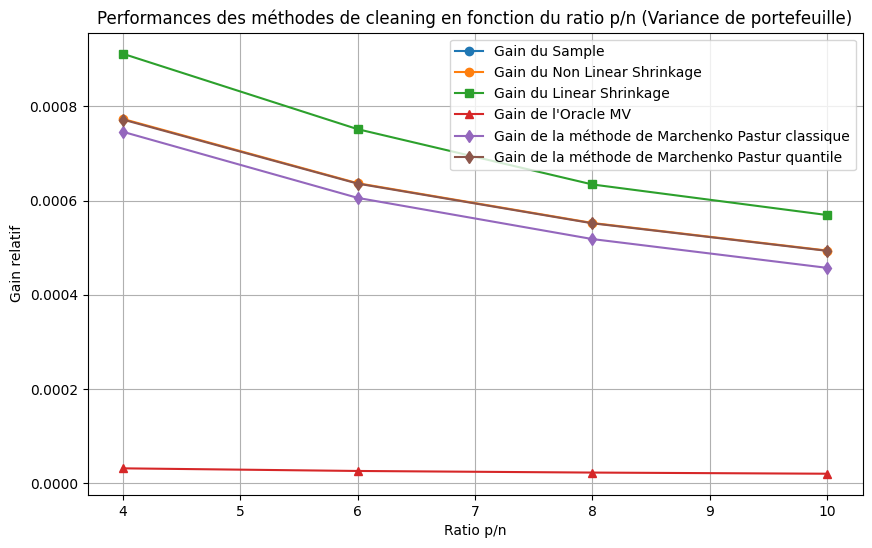

In [73]:
# Visualisation du benchmark 4: Variance de portefeuille
import matplotlib.pyplot as plt
 
plt.figure(figsize=(10, 6))
plt.plot(ratios, gains_s_gmv, label='Gain du Sample', marker='o')
plt.plot(ratios, gains_as_gmv, label='Gain du Non Linear Shrinkage', marker='o')
plt.plot(ratios, gains_ls_gmv, label='Gain du Linear Shrinkage', marker='s')
plt.plot(ratios, gains_etoile_gmv, label='Gain de l\'Oracle MV', marker='^')
plt.plot(ratios, gains_mp_gmv, label='Gain de la méthode de Marchenko Pastur classique', marker='d')
plt.plot(ratios, gains_mp2_gmv, label='Gain de la méthode de Marchenko Pastur quantile', marker='d')
#plt.plot(ratios, gains_ao_gmv, label='Gain de la méthode de l\'Average Oracle', marker='d')

plt.title('Performances des méthodes de cleaning en fonction du ratio p/n (Variance de portefeuille)')
plt.xlabel('Ratio p/n')
plt.ylabel('Gain relatif')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# ===== BENCHMARK 5: Norme de Frobenius sur les matrices de corrélation =====
# Évalue la qualité d'estimation des corrélations (métrique robuste à l'échelle)

import time as time 
from joblib import Parallel, delayed
import numpy as np

MC = 5
ratios = [0.5*k for k in range (1, 10)]
gains_ao_fro = []
gains_ls_fro = []
gains_as_fro = []
gains_etoile_fro = []
gains_mp_fro = []
gains_mp2_fro = []

def mc_gain_one_run(n, p):
    """Mesure l'erreur sur les corrélations (invariant d'échelle)."""
    X, Sigma = generate_data(n,p)
    X_centre = X - X.mean(axis=0)
    
    cleaner = cleaning_methods(X_centre)
    S_as = cleaner.analytical_shrinkage()
    S_ls = cleaner.linear_shrinkage()
    S_mp = cleaner.mp()
    S_mp2 = cleaner.mp2()
    #S_ao = cleaner.average_oracle()
    S_etoile = cleaner.oracle_mv(Sigma)
    S = X.T @ X/(n-1)

    # Erreur sur matrices de corrélation (invariant d'échelle)
    loss_s = np.linalg.norm((S-Sigma), 'fro')
    loss_etoile = np.linalg.norm((S_etoile-Sigma), 'fro')
    loss_as = np.linalg.norm((S_as-Sigma), 'fro')
    loss_ls = np.linalg.norm((S_ls-Sigma), 'fro')
    loss_mp = np.linalg.norm((S_mp-Sigma), 'fro')
    loss_mp2 = np.linalg.norm((S_mp2-Sigma), 'fro')
    #loss_ao = np.linalg.norm((S_ao-Sigma), 'fro')

    return loss_as, loss_ls, loss_s, loss_etoile, loss_mp, loss_mp2

for ratio in tqdm(ratios):
    n = 250
    p = int(n*ratio)

    results = Parallel(n_jobs=-1, backend="threading")(
        delayed(mc_gain_one_run)(n, p) for _ in range(MC)
    )

    gain_as = sum(r[0] for r in results) / MC
    gain_ls = sum(r[1] for r in results) / MC
    gain_setoile = sum(r[3] for r in results) / MC
    gain_s = sum(r[2] for r in results) / MC
    gain_mp = sum(r[4] for r in results) / MC
    gain_mp2 = sum(r[5] for r in results) / MC
    #gain_ao = sum(r[6] for r in results) / MC
    
    # Normalisation par rapport à l'estimateur sample
    gain_as = ((gain_s - gain_as) / (gain_s + 1e-10))
    gain_ls = ((gain_s - gain_ls) / (gain_s + 1e-10))
    gain_mp = ((gain_s - gain_mp) / (gain_s + 1e-10))
    gain_mp2 = ((gain_s - gain_mp2) / (gain_s + 1e-10))
    gain_setoile = ((gain_s - gain_setoile) / (gain_s + 1e-10))
    #gain_ao = ((gain_s - gain_ao) / (gain_s + 1e-10))

    gains_as_fro.append(gain_as)
    gains_ls_fro.append(gain_ls)
    #gains_ao_fro.append(gain_ao)
    gains_mp_fro.append(gain_mp)
    gains_mp2_fro.append(gain_mp2)
    gains_etoile_fro.append(gain_setoile)

100%|██████████| 9/9 [00:48<00:00,  5.43s/it]


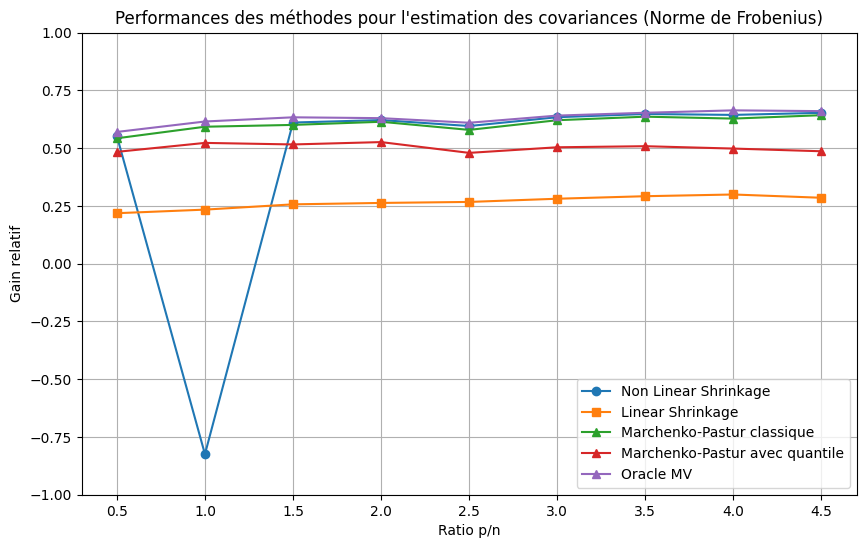

In [6]:
# Visualisation du benchmark 5: Erreur de corrélation
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(ratios, gains_as_fro, label='Non Linear Shrinkage', marker='o')
plt.plot(ratios, gains_ls_fro, label='Linear Shrinkage', marker='s')
plt.plot(ratios, gains_mp2_fro, label='Marchenko-Pastur classique', marker='^')
plt.plot(ratios, gains_mp_fro, label='Marchenko-Pastur avec quantile', marker='^')
plt.plot(ratios, gains_etoile_fro, label='Oracle MV', marker='^')

plt.ylim(-1, 1)
plt.title('Performances des méthodes pour l\'estimation des covariances (Norme de Frobenius)')
plt.xlabel('Ratio p/n')
plt.ylabel('Gain relatif')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ===== BENCHMARK 7: Test de Kolmogorov-Smirnov =====
# Vérifie la qualité des estimateurs en comparant distributions empiriques

from scipy.stats import ks_2samp
import numpy as np

MC = 100
n = 252
ratios_ks = np.linspace(3, 5, 5)
alpha = 0.05  # Niveau de significativité
dist_s, dist_ls, dist_as, dist_mp, dist_etoile, dist_ao, dist_mp2 = [],[],[],[],[],[],[]
r_s, r_ls, r_as, r_mp, r_etoile, r_ao, r_mp2 = [],[],[],[],[],[],[]

def ks_rejection_rate(X_gen, X_real, alpha=0.05):
    """Calcule la proportion d'actifs pour lesquels KS rejette l'hypothèse nulle.
    
    Une distribution bien estimée devrait avoir un faible taux de rejet.
    """
    p = X_real.shape[1]
    rejects = 0

    for j in range(p):
        dist, pval = ks_2samp(
            X_gen[:, j],
            X_real[:, j],
            alternative="two-sided"
        )
        if pval < alpha:
            rejects += 1

    return rejects / p, dist/p

def mc_gain_one_run(n, p):
    """Génère données in-sample, estime covariance, génère out-of-sample, compare distributions."""
    _, Sigma = generate_data(n,p)

    X_is = generate_sample(n, Sigma)
    X_os = generate_sample(n, Sigma)

    X_is_centre = X_is - X_is.mean(axis=0)
    X_os_centre = X_os - X_os.mean(axis=0)

    cleaner = cleaning_methods(X_is_centre)

    S_as = cleaner.analytical_shrinkage()
    S_ls = cleaner.linear_shrinkage()
    S_mp = cleaner.mp()
    S_mp2 = cleaner.mp2()
    #S_ao = cleaner.average_oracle()
    S_etoile = cleaner.oracle_mv(Sigma)

    S = X_is_centre.T @ X_is_centre / n + 1e-3 * np.trace(Sigma) * np.eye(p)/p

    # Génération données synthétiques out-of-sample
    X_os_s = generate_sample(n, S)
    X_os_as = generate_sample(n, S_as)
    X_os_ls = generate_sample(n, S_ls)
    #X_os_ao = generate_sample(n, S_ao)
    X_os_mp = generate_sample(n, S_mp)
    X_os_mp2 = generate_sample(n, S_mp2)
    X_os_etoile = generate_sample(n, S_etoile)

    # Centrage
    X_os_s -= X_os_s.mean(axis=0)
    X_os_as -= X_os_as.mean(axis=0)
    X_os_ls -= X_os_ls.mean(axis=0)
    X_os_mp -= X_os_mp.mean(axis=0)
    X_os_mp2 -= X_os_mp2.mean(axis=0)
    #X_os_ao -= X_os_ao.mean(axis=0)
    X_os_etoile -= X_os_etoile.mean(axis=0)

    # Tests de Kolmogorov-Smirnov
    r_s, dist_s = ks_rejection_rate(X_os_s, X_os_centre)
    #r_ao, dist_ao = ks_rejection_rate(X_os_ao, X_os_centre)
    r_as, dist_as = ks_rejection_rate(X_os_as, X_os_centre)
    r_ls, dist_ls = ks_rejection_rate(X_os_ls, X_os_centre)
    r_mp, dist_mp = ks_rejection_rate(X_os_mp, X_os_centre)
    r_mp2, dist_mp2 = ks_rejection_rate(X_os_mp2, X_os_centre)
    r_etoile, dist_etoile = ks_rejection_rate(X_os_etoile, X_os_centre)

    return r_as, r_ls, r_mp, r_etoile, r_s, dist_as, dist_ls, dist_mp, dist_etoile, dist_s, r_mp2, dist_mp2

for ratio in tqdm(ratios_ks):
    p = int(n * ratio)

    # Exécution du MC (note: possibilité de parallélisation)
    results = [mc_gain_one_run(n, p) for _ in range(MC)]
    results = np.mean(results, axis=0)

    r_as.append(results[0])
    r_ls.append(results[1])
    r_mp.append(results[2])
    r_etoile.append(results[3])
    r_s.append(results[4])
    #r_ao.append(results[10])
    r_mp2.append(results[10])

    dist_as.append(results[5])
    dist_ls.append(results[6])
    dist_mp.append(results[7])
    dist_etoile.append(results[8])
    dist_s.append(results[9])
    #dist_ao.append(results[11])
    dist_mp2.append(results[11])

100%|██████████| 5/5 [00:43<00:00,  8.65s/it]


Distance de Kolmogorov-Smirnov (moyenne par actif):
   Ratios  Distance KS pour AS  Distance KS pour LS  \
0     3.0             0.000084             0.000126   
1     3.5             0.000074             0.000070   
2     4.0             0.000089             0.000049   
3     4.5             0.000056             0.000059   
4     5.0             0.000057             0.000049   

   Distance KS pour MP quantile  Distance KS pour MP théorique  \
0                      0.000097                       0.000073   
1                      0.000063                       0.000061   
2                      0.000071                       0.000067   
3                      0.000059                       0.000045   
4                      0.000066                       0.000035   

   Distance KS pour Oracle  Distance KS pour Sample  
0                 0.000530                 0.000131  
1                 0.000441                 0.000058  
2                 0.000388                 0.000057  
3   

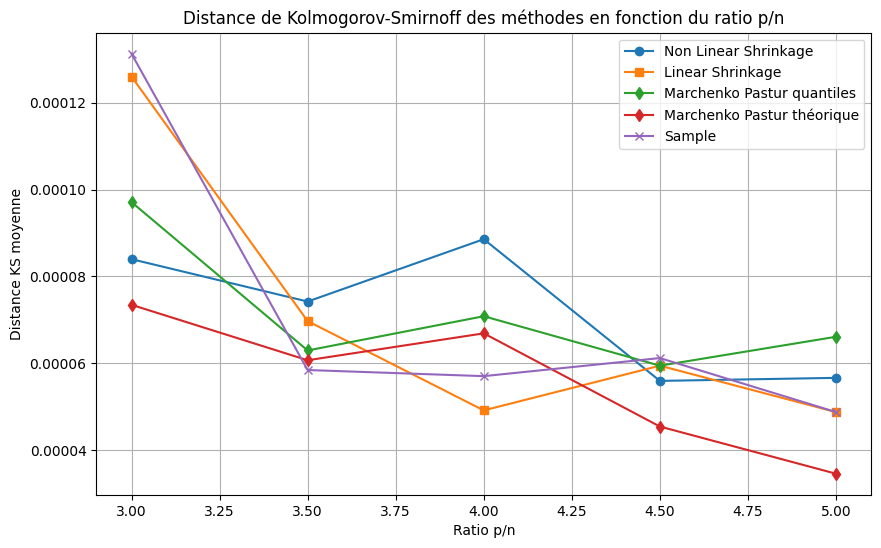

Taux de rejet KS (proportion d'actifs avec p-value < 0.05):
   Ratios  Rejet KS pour AS  Rejet KS pour LS  Rejet KS pour MP quantile  \
0     3.0          0.005952          0.001984                   0.007937   
1     3.5          0.003968          0.001701                   0.003401   
2     4.0          0.008433          0.002976                   0.004960   
3     4.5          0.004409          0.000000                   0.005732   
4     5.0          0.005159          0.003175                   0.003571   

   Rejet KS pour MP théorique  Rejet KS pour Oracle  Rejet KS pour Sample  
0                    0.003968                   1.0              0.029762  
1                    0.006236                   1.0              0.024376  
2                    0.007937                   1.0              0.020833  
3                    0.005291                   1.0              0.022046  
4                    0.005952                   1.0              0.021825  


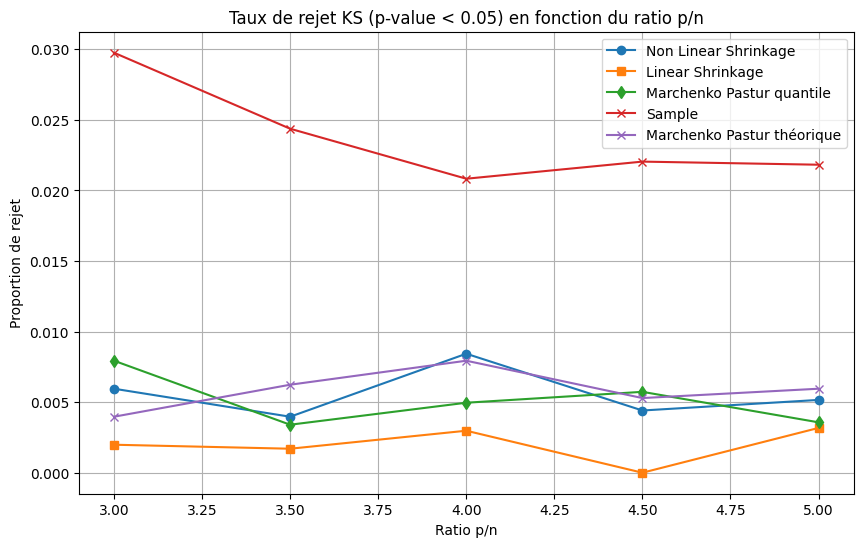

In [ ]:
import pandas as pd

# Résumé des distances KS moyennes
d = {'Ratios': ratios_ks,
     'Distance KS pour AS': dist_as,
     'Distance KS pour LS': dist_ls,
     'Distance KS pour MP quantile': dist_mp,
     'Distance KS pour MP théorique': dist_mp2,
     'Distance KS pour Oracle': dist_etoile,
     'Distance KS pour Sample': dist_s}
     #'Distance KS pour AO': dist_ao}

losses = pd.DataFrame(data=d)
print("Distance de Kolmogorov-Smirnov (moyenne par actif):")
print(losses)


# Visualisation: Distance KS
plt.figure(figsize=(10, 6))
plt.plot(ratios_ks, dist_as, label='Non Linear Shrinkage', marker='o')
plt.plot(ratios_ks, dist_ls, label='Linear Shrinkage', marker='s')
#plt.plot(ratios_ks, dist_etoile, label='Oracle MV', marker='^')
plt.plot(ratios_ks, dist_mp, label='Marchenko Pastur quantiles', marker='d')
plt.plot(ratios_ks, dist_mp2, label='Marchenko Pastur théorique', marker='d')
plt.plot(ratios_ks, dist_s, label='Sample', marker='x')
#plt.plot(ratios_ks, dist_ao, label='Average Oracle', marker='x')

plt.title('Distance de Kolmogorov-Smirnoff des méthodes en fonction du ratio p/n')
plt.xlabel('Ratio p/n')
plt.ylabel('Distance KS moyenne')
plt.legend()
plt.grid(True)
plt.show()

# Résumé des taux de rejet KS
d = {'Ratios': ratios_ks,
     'Rejet KS pour AS': r_as,
     'Rejet KS pour LS': r_ls,
     'Rejet KS pour MP quantile': r_mp,
     'Rejet KS pour MP théorique': r_mp2,
     #'Rejet KS pour oracle moyen': r_ao,
     'Rejet KS pour Oracle': r_etoile,
     'Rejet KS pour Sample': r_s}

losses = pd.DataFrame(data=d)
print("Taux de rejet KS (proportion d'actifs avec p-value < 0.05):")
print(losses)

# Visualisation: Taux de rejet KS
plt.figure(figsize=(10, 6))
plt.plot(ratios_ks, r_as, label='Non Linear Shrinkage', marker='o')
plt.plot(ratios_ks, r_ls, label='Linear Shrinkage', marker='s')
#plt.plot(ratios_ks, r_etoile, label='Oracle MV', marker='^')
plt.plot(ratios_ks, r_mp, label='Marchenko Pastur quantile', marker='d')
plt.plot(ratios_ks, r_s, label='Sample', marker='x')
#plt.plot(ratios_ks, r_ao, label='Average Oracle', marker='x')
plt.plot(ratios_ks, r_mp2, label='Marchenko Pastur théorique', marker='x')

plt.title('Taux de rejet KS (p-value < 0.05) en fonction du ratio p/n')
plt.xlabel('Ratio p/n')
plt.ylabel('Proportion de rejet')
plt.legend()
plt.grid(True)
plt.show()

## III. Analyses Spectrales et Structurelles

Cette section étudie les propriétés spectrales de la matrice de covariance
et leur impact sur la structure du portefeuille optimal.

In [40]:
n,p = 252, 300
X, Sigma = generate_data(n,p)

mu = X.mean(axis=0)
X -= mu

R_is = X.T @ X / (n-1)

eig_true = np.linalg.eigvalsh(Sigma)
eig = np.linalg.eigvalsh(R_is)

0


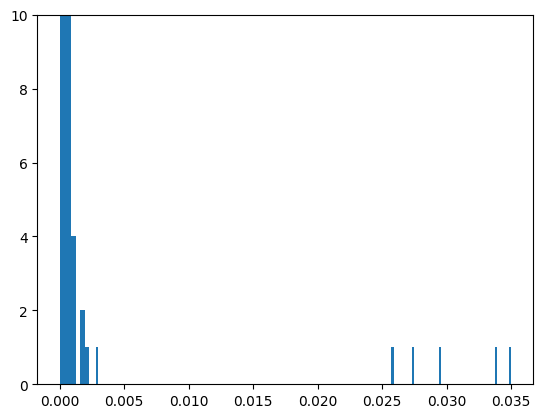

0.03496144370970251
2.1481975423781192e-05


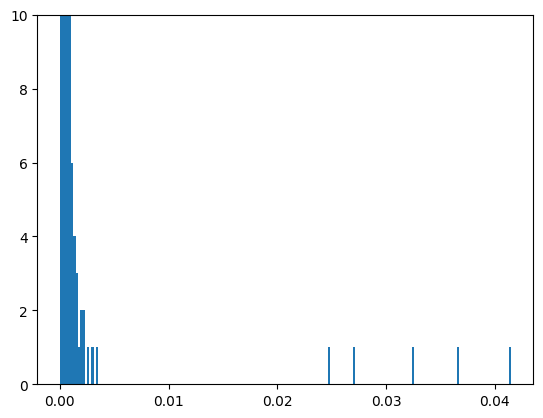

In [41]:
print(len(eig_true[eig_true>0.1]))

plt.figure()
plt.hist(eig_true, bins = 200)
plt.ylim(0,10)
#plt.xlim(0,1)
plt.show()

print(np.max(eig_true[eig_true<2]))
print(np.min(eig_true[eig_true<2]))

plt.figure()
plt.hist(eig, bins = 200)
plt.ylim(0,10)
plt.show()

In [27]:
# ===== SIMULATION MONTE CARLO: FRONTIÈRES EFFICIENTES =====
# Compare les estimateurs via simulation Monte Carlo sur frontières de Markowitz avec quantiles

import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from methods import cleaning_methods
import pandas as pd

MC_frontier = 50  # Nombre d'itérations MC

def mc_frontier_run():
    """Une itération MC: estime covariance, puis calcule frontière efficiente."""
    n_is = 252  # In-sample
    p = 2000    # Nombre d'actifs
    
    X, Sigma = generate_data(n_is, p)

    mu = X.mean(axis=0)
    X -= mu  # Centrage
    
    R_is = X.T @ X / (n_is-1)  # Covariance empirique
    
    cleaner = cleaning_methods(X)
    
    # Estimateurs concurrents
    S_mp = cleaner.mp()
    S_mp2 = cleaner.mp2()
    S_as = cleaner.analytical_shrinkage()
    S_ls = cleaner.linear_shrinkage()
    #S_ao = cleaner.average_oracle()
    
    S_dict = {
        "Sample": R_is,
        "MP quantile": S_mp,
        "MP théorique": S_mp2,
        "AS": S_as,
        "LS": S_ls
        #"AO": S_ao
    }
    
    frontiers_run = {}
    for name, S_hat in S_dict.items():
        risk, ret, sharpe = markowitz_frontier(S_hat, mu, Sigma, n_points=60)
        frontiers_run[name] = (risk, ret, sharpe)
    
    return frontiers_run

# Lancer le Monte Carlo en parallèle
results_mc = Parallel(n_jobs=-1, backend="threading")(
    delayed(mc_frontier_run)() for _ in tqdm(range(MC_frontier))
)

# Agrégation par méthode
frontiers_mc = {
    "Sample": {"risks": [], "rets": [], "sharpes": []},
    "MP quantile": {"risks": [], "rets": [], "sharpes": []},
    "MP théorique": {"risks": [], "rets": [], "sharpes": []},
    "AS": {"risks": [], "rets": [], "sharpes": []},
    "LS": {"risks": [], "rets": [], "sharpes": []}
    #"AO": {"risks": [], "rets": [], "sharpes": []}
}

for result in results_mc:
    for name, (risk, ret, sharpe) in result.items():
        frontiers_mc[name]["risks"].append(risk)
        frontiers_mc[name]["rets"].append(ret)
        frontiers_mc[name]["sharpes"].append(sharpe)

# Calcul des statistiques: moyennes et quantiles 1%/99%
frontiers_stats = {}
for name, data in frontiers_mc.items():
    risks_array = np.array(data["risks"])
    rets_array = np.array(data["rets"])
    sharpes_array = np.array(data["sharpes"])
    
    # Quantiles point par point (pour chaque rendement cible)
    q1_ret = np.quantile(rets_array, 0.01, axis=0)
    q99_ret = np.quantile(rets_array, 0.99, axis=0)
    q1_sharpe = np.quantile(sharpes_array, 0.01, axis=0)
    q99_sharpe = np.quantile(sharpes_array, 0.99, axis=0)
    
    frontiers_stats[name] = {
        "risk_mean": risks_array.mean(axis=0),
        "ret_mean": rets_array.mean(axis=0),
        "q1_ret": q1_ret,
        "q99_ret": q99_ret,
        "sharpe_mean": sharpes_array.mean(axis=0),
        "q1_sharpe": q1_sharpe,
        "q99_sharpe": q99_sharpe
    }

print(f"Monte Carlo complété: {MC_frontier} itérations")

100%|██████████| 50/50 [13:51<00:00, 16.63s/it]


Monte Carlo complété: 50 itérations


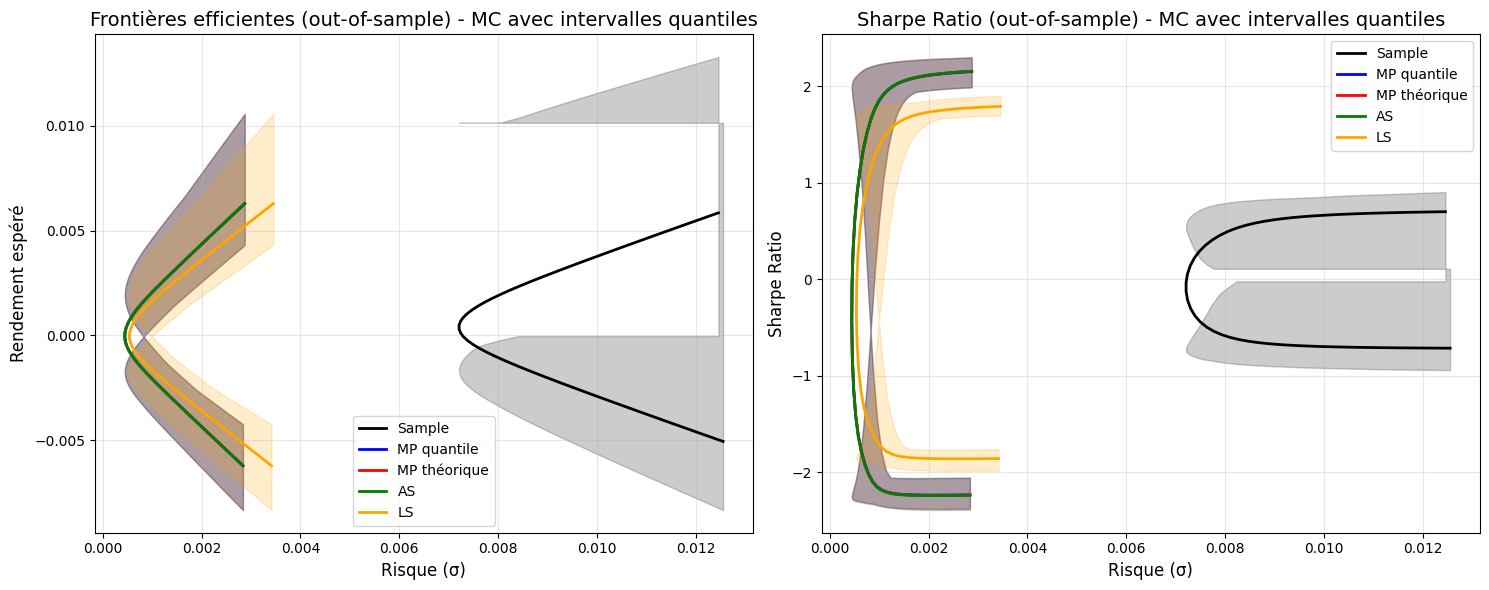

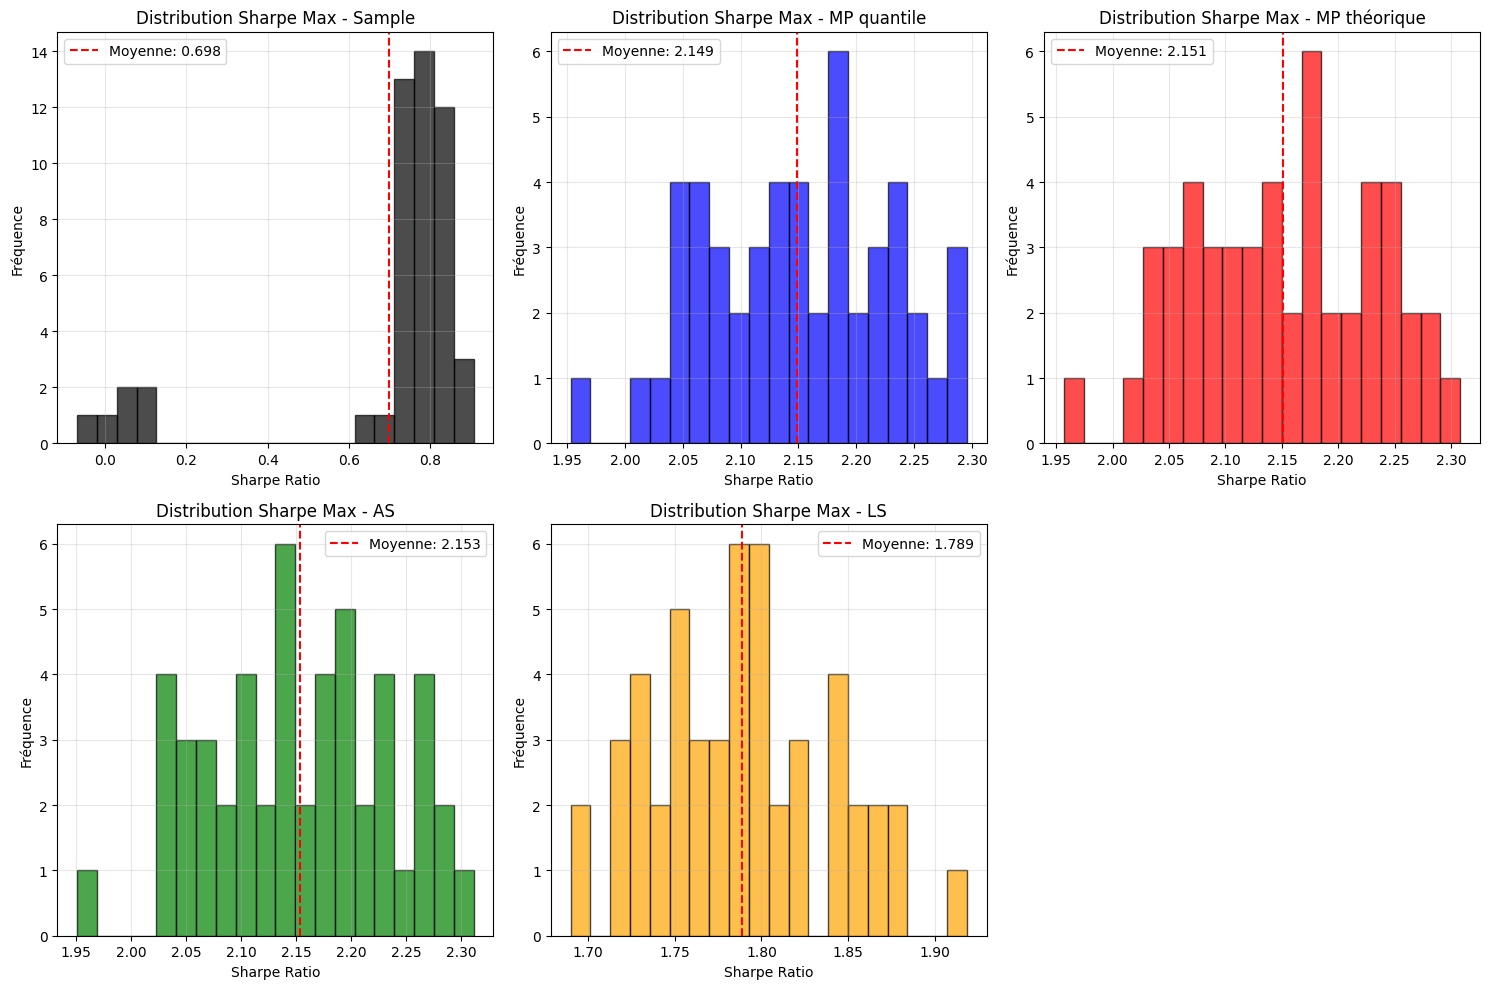


RÉSUMÉ DES RÉSULTATS MONTE CARLO

Sample:
  Meilleur Sharpe (moyen):     0.6977
  Risque correspondant:        0.0124
  Rendement correspondant:     0.0058

MP quantile:
  Meilleur Sharpe (moyen):     2.1491
  Risque correspondant:        0.0029
  Rendement correspondant:     0.0063

MP théorique:
  Meilleur Sharpe (moyen):     2.1513
  Risque correspondant:        0.0029
  Rendement correspondant:     0.0063

AS:
  Meilleur Sharpe (moyen):     2.1531
  Risque correspondant:        0.0029
  Rendement correspondant:     0.0063

LS:
  Meilleur Sharpe (moyen):     1.7886
  Risque correspondant:        0.0035
  Rendement correspondant:     0.0063


In [43]:
# ===== VISUALISATION FINALE: FRONTIÈRES EFFICIENTES AVEC INTERVALLES =====
# Affiche les frontières efficientes moyennes avec bandes de confiance (quantiles 1%/99%)

import matplotlib.pyplot as plt

colors = {
    "Sample": "black",
    "MP quantile": "blue",
    "MP théorique": "red",
    "AS": "green",
    "LS": "orange"
}

# Plot 1: Frontières efficientes (rendement vs risque)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

for name, stats in frontiers_stats.items():
    ax1.plot(stats["risk_mean"], stats["ret_mean"], 
            label=name, color=colors[name], linewidth=2)
    # Error bars basés sur les quantiles 1%/99%
    yerr_lower = np.maximum(stats["ret_mean"] - stats["q1_ret"], 0)
    yerr_upper = np.maximum(stats["q99_ret"] - stats["ret_mean"], 0)
    ax1.fill_between(stats["risk_mean"],
                    stats["ret_mean"] - yerr_lower,
                    stats["ret_mean"] + yerr_upper,
                    color=colors[name], alpha=0.2)

ax1.set_xlabel("Risque (σ)", fontsize=12)
ax1.set_ylabel("Rendement espéré", fontsize=12)
ax1.set_title("Frontières efficientes (out-of-sample) - MC avec intervalles quantiles", fontsize=14)
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Sharpe Ratio
for name, stats in frontiers_stats.items():
    ax2.plot(stats["risk_mean"], stats["sharpe_mean"], 
            label=name, color=colors[name], linewidth=2)
    # Error bars basés sur les quantiles 1%/99%
    yerr_lower = np.maximum(stats["sharpe_mean"] - stats["q1_sharpe"], 0)
    yerr_upper = np.maximum(stats["q99_sharpe"] - stats["sharpe_mean"], 0)
    ax2.fill_between(stats["risk_mean"],
                    stats["sharpe_mean"] - yerr_lower,
                    stats["sharpe_mean"] + yerr_upper,
                    color=colors[name], alpha=0.2)

ax2.set_xlabel("Risque (σ)", fontsize=12)
ax2.set_ylabel("Sharpe Ratio", fontsize=12)
ax2.set_title("Sharpe Ratio (out-of-sample) - MC avec intervalles quantiles", fontsize=14)
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Plot 3: Distribution des Sharpe Ratios optimaux
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (name, stats) in enumerate(frontiers_stats.items()):
    # Collecte les Sharpe maximaux sur chaque itération MC
    sharpes_max = []
    for result in results_mc:
        sharpes = result[name][2]
        sharpes_max.append(np.max(sharpes))
    
    axes[idx].hist(sharpes_max, bins=20, alpha=0.7, color=colors[name], edgecolor='black')
    axes[idx].axvline(np.mean(sharpes_max), color='red', linestyle='--', 
                      label=f'Moyenne: {np.mean(sharpes_max):.3f}')
    axes[idx].set_title(f"Distribution Sharpe Max - {name}", fontsize=12)
    axes[idx].set_xlabel("Sharpe Ratio")
    axes[idx].set_ylabel("Fréquence")
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

# Supprimer le dernier subplot vide
fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("RÉSUMÉ DES RÉSULTATS MONTE CARLO")
print("="*70)
for name, stats in frontiers_stats.items():
    best_idx = np.argmax(stats["sharpe_mean"])
    print(f"\n{name}:")
    print(f"  Meilleur Sharpe (moyen):     {stats['sharpe_mean'][best_idx]:.4f}")
    print(f"  Risque correspondant:        {stats['risk_mean'][best_idx]:.4f}")
    print(f"  Rendement correspondant:     {stats['ret_mean'][best_idx]:.4f}")